# Derived Map of Turkey

In [54]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
import math
import matplotlib.pyplot as plt
from matplotlib import transforms

Distances between districts of Turkey is obtained from governmental road construction works organization.
https://www.kgm.gov.tr/SiteCollectionDocuments/KGMdocuments/Root/Uzakliklar/ilmesafe.xls

In [3]:
distance = pd.read_excel( os.path.realpath("")+"/ilmesafe.xlsx",
                        skiprows=1)

The data is split into two parts. First one acts as a licence plate key and contains licence plate numbers and respective districts name. Additionally, this dataframe contains initial coordinations for each distict which is initialized as zero. The second dataframe only containts 0-1 scaled version of distances between districts.

In [4]:
#licence plate and district name pairs
licenceplate = distance.iloc[:,0:2]
licenceplate.set_index( licenceplate.columns.values[0], inplace=True )

#initial coordinates
licenceplate["X"] = np.zeros( licenceplate.shape[0] )
licenceplate["Y"] = np.zeros( licenceplate.shape[0] )

#change of structure
distance.drop( "İL ADI", axis=1, inplace=True )
distance.set_index( distance.columns.values[0], inplace=True )
distance.columns = distance.index.values

#scaling
distance = distance/distance.values.max()


The following function is inspired from sum of squares logic of statistics discipline. The function calculates euclidian distance of the coordinates and its sum of squared deviation from the actual scaled distances for all districts. An example output is displayed below with all coordinates set to zero.

In [4]:
def distance_se( XY ):
    grand_se = 0
    for i in range( int(len(XY)/2) ):
        district_se=[]
        for j in range( int(len(XY)/2) ):
            district_se.append( (np.sqrt((XY[:81][i]-XY[:81][j])**2 +\
                                         (XY[81:][i]-XY[81:][j])**2) -\
                                 distance.iloc[i,j])**2 )

        grand_se = grand_se + sum(district_se)
    return grand_se
        
distance_se( np.concatenate( (licenceplate.loc[:,"X"].values, licenceplate.loc[:,"Y"].values), axis=0 ) )

1162.185044173751

The following block tries to minimize sum of squared error by changing the coordinates of the districts. Without making any major changes in the recommended optimization methods, the optimizer was able to come up with impressive results within roughly forty minutes.

In [5]:
start_time = time.time()
sol = minimize(distance_se,
            np.concatenate( (licenceplate.loc[:,"X"].values, licenceplate.loc[:,"Y"].values), axis=0 ),
            method="SLSQP"
              )
print("--- %s seconds ---" % (time.time() - start_time))

np.save( os.path.realpath("")+"sol_set1.npy", np.array(sol.x) )
sol

--- 2259.485775947571 seconds ---


     fun: 1.3940912773211516
     jac: array([-0.76919869,  0.01027906,  0.07670128,  0.43520671,  0.43390267,
        0.48359562, -0.09488393, -0.00622879, -0.46475159,  0.29066238,
        0.21445805,  0.62653235, -0.03745982,  0.33898512,  0.05826671,
        0.01290807,  0.135125  ,  0.22687756,  0.14251335, -0.74532484,
       -0.46574187, -0.64170225, -0.08611982,  0.15832539,  0.31866111,
       -0.0834944 , -0.06145142, -0.07650645, -0.33590601, -0.1393725 ,
       -0.05067694, -0.06866865, -0.26829553, -0.08175692, -0.59054728,
       -0.17597345, -0.09713919,  0.47525932,  0.15689328, -0.11864792,
       -0.02979554, -0.07107681,  0.48212704, -0.02086881, -0.03711745,
       -0.27467829,  0.3495543 ,  0.26615104, -0.374568  ,  0.07328627,
       -0.15369888, -0.24096164,  0.15355122, -0.08185017, -0.61587965,
        0.09071442, -0.30799969, -0.45221314,  0.91748276,  0.45539963,
        0.15250368,  0.10463962,  0.54173754, -0.26661636,  0.04140493,
        0.10306107,  0.05

In [ ]:
coord = sol.x
#coord = np.load( os.path.realpath("")+"sol_set1.npy" )
licenceplate["X"] = coord[:81]
licenceplate["Y"] = coord[81:]

The following plot depicts the optimization output. The result is strikingly similar with the actual Turkey map. Even small details like; Antalya cavity, Marmara Sea, comparably large areas of Konya, Ankara, Sivas and Van. Y coordinates of the output is multiplied by -1 for alignment.

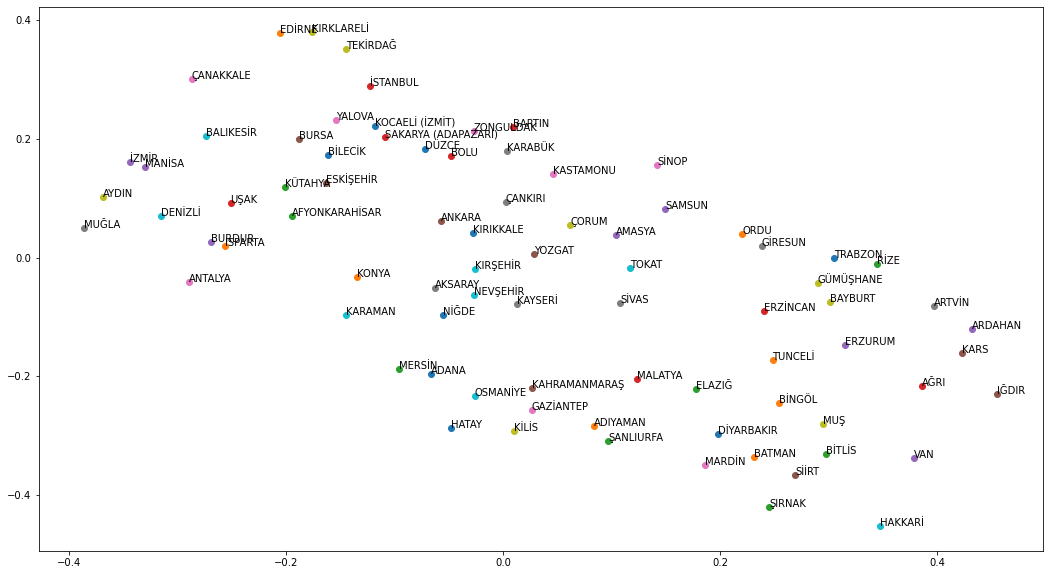

In [63]:
plt.figure(figsize=(18,10))
for i in range(len(coord[:81])):
    plt.scatter( coord[:81][i],
                 -1*coord[81:][i],
               label=licenceplate.iloc[i,0])
    plt.annotate( licenceplate.iloc[i,0], (coord[:81][i],-1*coord[81:][i]) )

    

Following plot is the rotated version the optimization output. The locations are observed to be distorted. Unreliability of rotation applications for scatter plots are implied within the pyplot package documentation. Due to this unreliability, axis length of the map is decreased therefore the output is thicker, far from the truth.

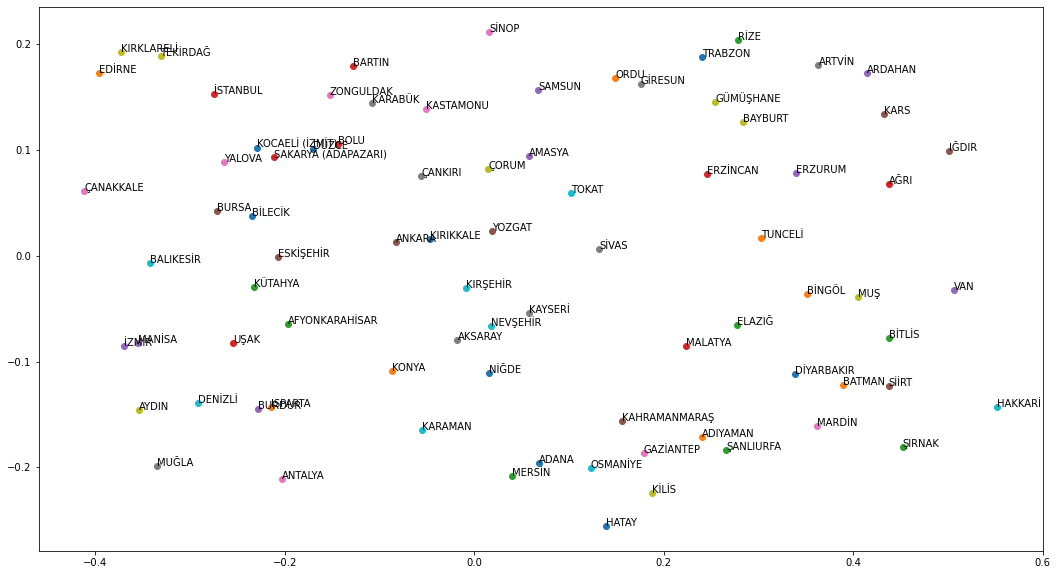

In [72]:
plt.figure(figsize=(18,10))
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(38)

for i in range(len(coord[:81])):
    plt.scatter( coord[:81][i],
                 -1*coord[81:][i],
               label=licenceplate.iloc[i,0],
               transform= rot + base)
    plt.annotate( licenceplate.iloc[i,0], (coord[:81][i], -1*coord[81:][i]),
                xycoords= rot + base)